In [ ]:
# Uncomment if use Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount google drive

Mounted at /content/gdrive


In [ ]:
# Nothing better to begin with than by importing some necessary dependencies. 
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import torch.nn as nn


# Solution for Learning a Family of Functions- Training an autoencoder

The following analysis aims to develop a machine learning solution which jointly trains two MLPs (an encoder and a decoder) to autoencode a family of functions and fit a dataset to one of these curves.

The autoencoder (encoder) will use linear layers to fit a feature representation. The output of the encoder will be put into the decoder to produce the models prediction using the feature representation and a given set of points.

The family of functions learnt will be of the form: 

$y = f_a(x) = a * sin(x+a)$

This sinusoidal family contains two varaibles, x and a. 40 points spaced about between the interval -2 and 2 were generated for each function, each randomly jittered, while a value of a was also randomly sampled from the same interval for each function.

The target, y, was derived using the formula, and both the values of x and y were input into the encoder. The number of values input varied with each batch (batch_size was also of variable size). These values were called the context points (of number Nc). Varying the number of context points trained the model to deal with input as such. 


In effect the model perfomrs two tasks: function selection, and regression. In producing a feature representation output, the model has selected one member of the family of functions to then fit with regression.

Furthermore, the feature representation (termed rc here) can be of variable dimensions (rdim). In this model, rc is averaged to produced Rc before feeding into the decoder.



# 1. Create the training datastet and dataloader

In [ ]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa

#Generate 40 x values for each function
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

#Add jitter to each x value
x += torch.rand_like(x)*0.1

#Randomly select a from uniform distribution from -2 to 2
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)

#Produce y for all values of x using formula for family of functions
y = a*torch.sin(x+a)
print(x.shape, y.shape)

torch.Size([2000, 40, 1]) torch.Size([2000, 40, 1])


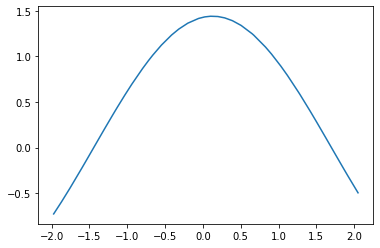

In [ ]:
#Plot example function at index 0
plt.plot(x[0],y[0])

In [ ]:
#Create dataset with x and y values generated previously
dataset = torch.utils.data.TensorDataset(x, y)

#Create dataloader for this dataset, with batch size of 8
dataset_iter =  torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True) #DataLoader object

#See dimensions of 1 batch- this includes 8 functions with 40 points for both x and y
x, y = next(iter(dataset_iter))
print(x.shape, y.shape)

torch.Size([8, 40, 1]) torch.Size([8, 40, 1])


In [ ]:
import numpy as np
import random

#Create function to select random context pairs from the 40
def select_context(x, y, batch_size):

#Use randit to produce a value for nc between 3 and 35
    N_c = random.randint(3,35)

#Make a random choice from the points in the function, Nc times
    idx = np.random.choice(np.arange(0,40), size=N_c, replace=False)
    c = torch.empty(batch_size,0,2)
    for i in idx:
        x_c = x[:, i, 0]
        x_c = x_c.reshape(batch_size,-1)
        y_c = y[:,i,0]
        y_c = y_c.reshape(batch_size,-1) 
        stack = torch.stack((x_c, y_c), dim=2)
        c = torch.cat((stack,c), dim=1)
    return c

c = select_context(x, y, 8)
print(c.shape)

torch.Size([8, 26, 2])


# 2. Create the Encoder and Decoder


In [ ]:
#Create encoder from nn.module class
class Encoder(torch.nn.Module):
    def __init__(self, num_inputs, hidden_dim, num_outputs):
        super(Encoder, self).__init__()

        #Instantiate variables in class
        self.num_inputs = num_inputs
        self.hidden_dim = hidden_dim
        self.num_outputs = num_outputs

        #Create layers including 2 hidden layers using linear layers and ReLU activation functions
        self.Linear1 = nn.Linear(num_inputs, hidden_dim)
        self.relu1 = nn.ReLU()
        self.Linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.Linear3 = nn.Linear(hidden_dim, num_outputs)

    #Create forward function which takes context points as input
    def forward(self, nc):
        out = self.Linear1(nc)
        out = self.relu1(out)
        out = self.Linear2(out)
        out = self.relu2(out)
        rc = self.Linear3(out)
        
        return rc

In [ ]:
#Create decoder from nn.module class
class Decoder(torch.nn.Module):
    def __init__(self, num_inputs, hidden_dim, num_outputs):
        super(Decoder, self).__init__()
        self.decoder_hdim = hidden_dim
        self.num_outputs = num_outputs
        
        #Create layers including 2 hidden layers using linear layers and ReLU activation functions
        self.Linear1 = nn.Linear(num_inputs, hidden_dim)
        self.relu1 = nn.ReLU()
        self.Linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.Linear3 = nn.Linear(hidden_dim, num_outputs)

    #Create forward function which takes rC and x input
    def forward(self, rC_xt):
        out = self.Linear1(rC_xt)
        out = self.relu1(out)
        out = self.Linear2(out)
        out = self.relu2(out)
        out = self.Linear3(out)
    
        return out

In [ ]:
#Set number of inputs and outputs from layers
rdim = 2
num_inputs, hidden_dim, num_outputs = 2, 5, rdim

#Instantiate encoder from Encoder net class with chosen numbers of inputs and outputs
encoder = Encoder(num_inputs, hidden_dim, num_outputs)

In [ ]:
#Set number of inputs and outputs from layers
num_inputs, hidden_dim, num_outputs = 3, 5, 1

#Instantiate decoder from Decoder net class with chosen numbers of inputs and outputs
decoder = Decoder(num_inputs, hidden_dim, num_outputs)

# 3. Create the optimizier and loss

In [ ]:
#Create loss function
loss = nn.MSELoss()

#Create optimizer
optimizer = torch.optim.Adam(encoder.parameters(), weight_decay=0.005, lr=0.025)

# 4. Training the model and observe the training loss


In [ ]:
# define training function
def train(batch_size, epochs):
  loss_list = []
  for epoch in range(epochs):
    for step, (x, y) in enumerate(dataset_iter):

        #Call select context to choose context points
        nc = select_context(x, y, batch_size)

        #Feed nc into encoder
        rc = encoder(nc)

        #turn rc output into rC by taking a mean
        count = 0
        rC = []
        for i in rc:
          rCi = torch.mean(rc[count], dim=0)
          count += 1
          rC.append(rCi)
        rC = torch.stack(rC)

        #Join rC to every x value input
        count = 0
        rC_xt = []
        for j in rc:
          empty1 = torch.Tensor(40,1)
          empty1.fill_(rC[count][0])
          empty2 = torch.Tensor(40,1)
          empty2.fill_(rC[count][1])
          rC_40 = torch.cat((empty1,empty2), dim=1)
          rj = torch.cat((x[count], rC_40), dim=1)
          count += 1
          rC_xt.append(rj)
        rC_xt = torch.stack(rC_xt)
        
        #Feed this value into the decoder
        y_hat = decoder(rC_xt)
        
        #Optimize, calculate loss, call backward, and update parameters
        optimizer.zero_grad()
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
    #Add loss for the epoch to a list for plotting
    loss_list.append(l)
    print(f'epoch {epoch + 1}, '
          f'loss: {l}')
    
  return y_hat, loss_list

In [ ]:
y_hat, loss_list = train(batch_size = 8, epochs = 15)

epoch 1, loss: 0.3580942749977112
epoch 2, loss: 0.243111252784729
epoch 3, loss: 0.31102263927459717
epoch 4, loss: 0.27087053656578064
epoch 5, loss: 0.273127943277359
epoch 6, loss: 0.43829435110092163
epoch 7, loss: 0.37963756918907166
epoch 8, loss: 0.3296130299568176
epoch 9, loss: 0.3713451325893402
epoch 10, loss: 0.4240763783454895
epoch 11, loss: 0.35352975130081177
epoch 12, loss: 0.38376694917678833
epoch 13, loss: 0.3885493576526642
epoch 14, loss: 0.2853143811225891
epoch 15, loss: 0.6750056743621826


Text(0, 0.5, 'Loss')

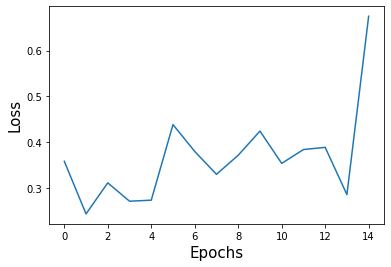

In [ ]:
#Modify loss list for plotting
loss_list2 = torch.stack(loss_list)
loss_list3 = loss_list2.detach().numpy()

#Create loss plot
plt.plot(loss_list3)
plt.xlabel('Epochs', size = 15)
plt.ylabel('Loss', size = 15)

# 5. Model evaluation, testing, and plotting  

In [ ]:
#Create test data
import pickle
path_to_the_pickle = '/content/gdrive/MyDrive/Colab Notebooks/test_data.pkl'
test_data =pickle.load(open(path_to_the_pickle,'rb'))
# 6 test functions
i = 2 # i=1,..6
name= 'function_num_{}'.format(i)
x_c=test_data[name]['context_pairs'][0]
y_c=test_data[name]['context_pairs'][1]
x_t =test_data[name]['x']
print(x_c.shape)

torch.Size([1, 23, 1])


In [ ]:
#Define function for testing
def test(i):

    # Extract context x and y values for input into the encoder,
    # and x for testing with decoder test data i
    # Use test data indexed by i
    name= 'function_num_{}'.format(i)
    x_c=test_data[name]['context_pairs'][0]
    y_c=test_data[name]['context_pairs'][1]
    x_t =test_data[name]['x']

    # Stack x and y to form context pairs
    comb = torch.stack([x_c, y_c],2)
    comb_t = torch.squeeze(comb, dim=3)

    #put context pairs into encoder to output rc of rdim (set above to be 2)
    rc = encoder(comb_t)
    #average rc to create rC
    rC = torch.mean(rc, dim=1)

    #Create two tensors for each rdim of rC values to add to x test input to decoder 
    empty1 = torch.Tensor(40,1)
    empty1.fill_(rC[0][0])
    empty2 = torch.Tensor(40,1)
    empty2.fill_(rC[0][1])
    empty1 = torch.unsqueeze(empty1, dim=0)
    empty2 = torch.unsqueeze(empty2, dim=0)

    #Combine rc for each function with x test input
    rC_xt = torch.stack((x_t, empty1, empty2), dim=2)
    rC_xt = torch.squeeze(rC_xt, dim=3)

    #Input into decoder to make predictions, y_hat_test
    y_hat_test = decoder(rC_xt)
    
    return y_hat_test

In [ ]:
#Call testing function
y_hat_test = test(3)
print(x_t.shape)

torch.Size([1, 40, 1])


In [ ]:
#Convert model readout y_hat and test x values into plottable form
x_t2 = torch.squeeze(x_t, dim=2)
y_hat_test2 = torch.squeeze(y_hat_test, dim=2)
x_t3 = torch.squeeze(x_t2, dim=0)
y_hat_test3 = torch.squeeze(y_hat_test2, dim=0)
x_t4 = x_t3.detach().numpy()
y_hat_test4 = y_hat_test3.detach().numpy()

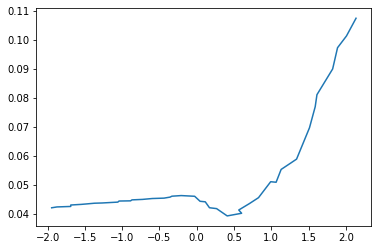

In [ ]:
#plot predictions from test data
plt.plot(x_t4,y_hat_test4)
